# Задание 2. Тестирование стратегии статистического арбитража


## 1. Загрузка библиотек


In [95]:
import numpy as np
import pandas as pd
from scipy import stats  # статистическая библиотека
from sklearn.linear_model import LinearRegression  # регрессионный анализ
from __future__ import division
import matplotlib.pyplot as plt  # графическая библиотека

%matplotlib inline
from datetime import datetime, timedelta  # работа с форматом даты
import statsmodels.tsa.stattools as st  # анализ временных рядов

## 2. Загрузка данных


### В качестве примера будем использовать данные по фьючерсам на нефть WTI. Для анализа возьмем два ближайших фьючерса.


In [52]:
path = ".\\ap_data\\"

In [105]:
try:
    Oil_fut = pd.read_excel(
    path + 'PET_PRI_FUT_S1_D.xls',
    sheet_name="Data 1",
    header=None,
    skiprows=3,
    usecols=[0, 1, 2, 3, 4],
    names=["Date", "Fut_1", "Fut_2", "Fut_3", "Fut_4"],
    engine="xlrd"
    )
except FileNotFoundError:
    Oil_fut = pd.read_excel(
    'https://github.com/qununc/financials_repo/blob/3ca491b08d680148ba11f9cd878267ee72b5ce33/AppliedModels/ap_data/PET_PRI_FUT_S1_D.xls?raw=true',
    sheet_name="Data 1",
    header=None,
    skiprows=3,
    usecols=[0, 1, 2, 3, 4],
    names=["Date", "Fut_1", "Fut_2", "Fut_3", "Fut_4"],
    engine="xlrd"
    )

In [102]:
Oil_fut.head()

,Date,Fut_1,Fut_2,Fut_3,Fut_4
0,1983-03-30,NaN,NaN,29.35,NaN
1,1983-03-31,NaN,NaN,29.24,NaN
2,1983-04-04,29.44,NaN,29.10,NaN
3,1983-04-05,29.71,NaN,29.35,NaN
4,1983-04-06,29.92,NaN,29.50,NaN


In [106]:
Oil_fut.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8988 entries, 0 to 8987
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    8988 non-null   datetime64[ns]
 1   Fut_1   8983 non-null   float64       
 2   Fut_2   8546 non-null   float64       
 3   Fut_3   8987 non-null   float64       
 4   Fut_4   8546 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 351.2 KB


In [56]:
Oil_fut = Oil_fut[(Oil_fut.Date > "2010-01-01")
                  & (Oil_fut.Date < "2016-01-01")]


In [57]:
Oil_fut.dropna(inplace=True)

In [58]:
Oil_fut.tail()

,Date,Fut_1,Fut_2,Fut_3,Fut_4
8217,2015-12-24,38.10,39.11,39.93,40.64
8218,2015-12-28,36.81,37.82,38.66,39.40
8219,2015-12-29,37.87,38.86,39.69,40.40
8220,2015-12-30,36.60,37.64,38.51,39.27
8221,2015-12-31,37.04,38.17,39.13,39.98


In [59]:
Oil_fut.shape

(1510, 5)

## 3. Проверка на стационарность


In [60]:
X = (np.array(np.log(Oil_fut.Fut_1))).reshape(-1, 1)

In [61]:
X.shape

(1510, 1)

In [62]:
Y = (np.array(np.log(Oil_fut.Fut_2))).reshape(-1, 1)

In [63]:
reg = LinearRegression(fit_intercept=False).fit(X, Y)

In [64]:
(reg.coef_[0][0])

1.0012695920885915

In [65]:
Y_hat = reg.predict(X)

In [66]:
Y_resid = Y - Y_hat

In [67]:
Y_resid.ravel().shape

(1510,)

In [68]:
np.mean(Y_resid), np.std(Y_resid)

(0.00043602977098142377, 0.010941703319950282)

In [69]:
st.adfuller(Y_resid.ravel())

(-3.3203699977222763,
 0.013992128864114016,
 21,
 1488,
 {'1%': -3.434752296229329,
  '5%': -2.8634843303184447,
  '10%': -2.5678051396295816},
 -13613.829021051632)

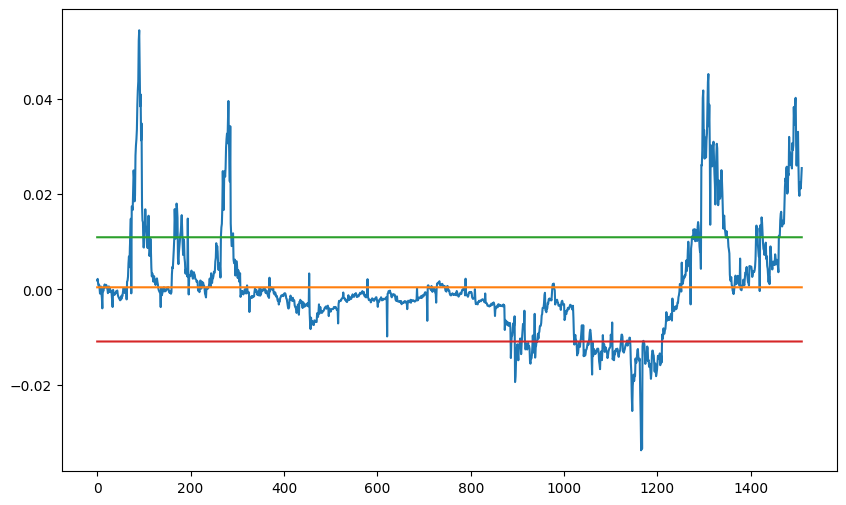

In [70]:
k = 1
plt.figure(figsize=(10, 6))
_ = plt.plot(Y_resid)
_ = plt.plot(np.repeat(np.mean(Y_resid), len(Y_resid)))
_ = plt.plot(np.repeat(np.std(Y_resid) * k, len(Y_resid)))
_ = plt.plot(np.repeat(np.std(Y_resid) * -k, len(Y_resid)))

## 4. Полезные функции


In [71]:
# расчет остатков уравнения регрессии
def reg_resid_func(Instr_1, Instr_2):
    Y = np.log(Instr_1)
    X = np.log(Instr_2)
    reg = LinearRegression(fit_intercept=False)
    reg.fit(X, Y)
    Y_pred = reg.predict(X)
    return ((Y - Y_pred), reg.coef_[0][0])

In [72]:
# проверка на стационарность
def stationarity_check_func(data_spread, alpha=0.05):
    stationarity = False
    if st.adfuller(data_spread.ravel())[1] < alpha:
        stationarity = True
    return stationarity

In [73]:
# расчет параметров распределения спрэда
def param_func(data_spread):
    return (np.mean(data_spread), np.std(data_spread))

In [74]:
# получение сингала
def signal_func_open(spread, mean, sigma, k):
    signal = "No"
    if spread <= mean - sigma * k:
        signal = "Buy"
    elif spread >= mean + sigma * k:
        signal = "Sell"
    return signal

In [75]:
# преобазование значений цен в число с плавающей точкой
def get_prices(instr1, instr2):
    return (float(instr1), float(instr2))

## 5. Создание класса для описания позиции


### long: first -buy, second-sell

### short: first - sell, second-buy


In [76]:
class Position(object):

    def __init__(self):
        self._initial_position = (None, None, 0, 0, 0)
        # date_initial,direction,price_1,price_2,beta,comission
        self._close_position = (None, None, 0, 0, 0)
        # date_close,signal,price_1,price_2,comission

    @property  # вывод данных по открытию позиции
    def initial_position(self):
        return self._initial_position

    @initial_position.setter  # ввод данных для открытия позиции
    def initial_position(self, initial_position):
        self._initial_position = initial_position

    @property  # # вывод данных по закрытию позиции
    def close_position(self):
        return self._close_position

    @close_position.setter  # ввод данных для закрытия позиции
    def close_position(self, close_position):
        self._close_position = close_position

    def get_result(self):  # расчет результата
        (
            Date_setup,
            Direction,
            Instr_1_Price_initial,
            Instr_2_Price_initial,
            Beta,
            Comission_init,
        ) = self._initial_position
        (
            Date_close,
            Close_type,
            Instr_1_Price_close,
            Instr_2_Price_close,
            Comission_close,
        ) = self._close_position
        if (Date_setup == None) | (Date_close == None):
            return 0
        else:
            if Direction == "Long":
                return (
                    (np.log(Instr_1_Price_close) - np.log(Instr_1_Price_initial)) -
                    (np.log(Instr_2_Price_close) - np.log(Instr_2_Price_initial)) *
                    Beta - Comission_init
                )
            else:
                    return (
                        -(np.log(Instr_1_Price_close) -
                        np.log(Instr_1_Price_initial)) +
                        (np.log(Instr_2_Price_close) -
                        np.log(Instr_2_Price_initial)) * Beta - Comission_close
                    )



In [77]:
pos = Position()

In [78]:
initial_position = ("2019-04-02", "Short", 5, 6, 1.1, 0)

In [79]:
pos.initial_position = initial_position

In [80]:
pos.initial_position

('2019-04-02', 'Short', 5, 6, 1.1, 0)

In [81]:
pos.close_position = ("2019-04-02", "Signal", 5, 8, 0)

In [82]:
pos.close_position

('2019-04-02', 'Signal', 5, 8, 0)

In [83]:
pos.get_result()

0.3164502796969589

## 6. Реализация стратегии


In [84]:
n = Oil_fut.shape[0]
n

1510

In [85]:
# преобразование первоначального массива цен в формат, необходимый для уравнения регрессии
Instr_1 = (np.array((Oil_fut.iloc[0:, 1]))).reshape(-1, 1)
Instr_2 = (np.array((Oil_fut.iloc[0:, 2]))).reshape(-1, 1)
Date = list((Oil_fut.iloc[0:, 0]))

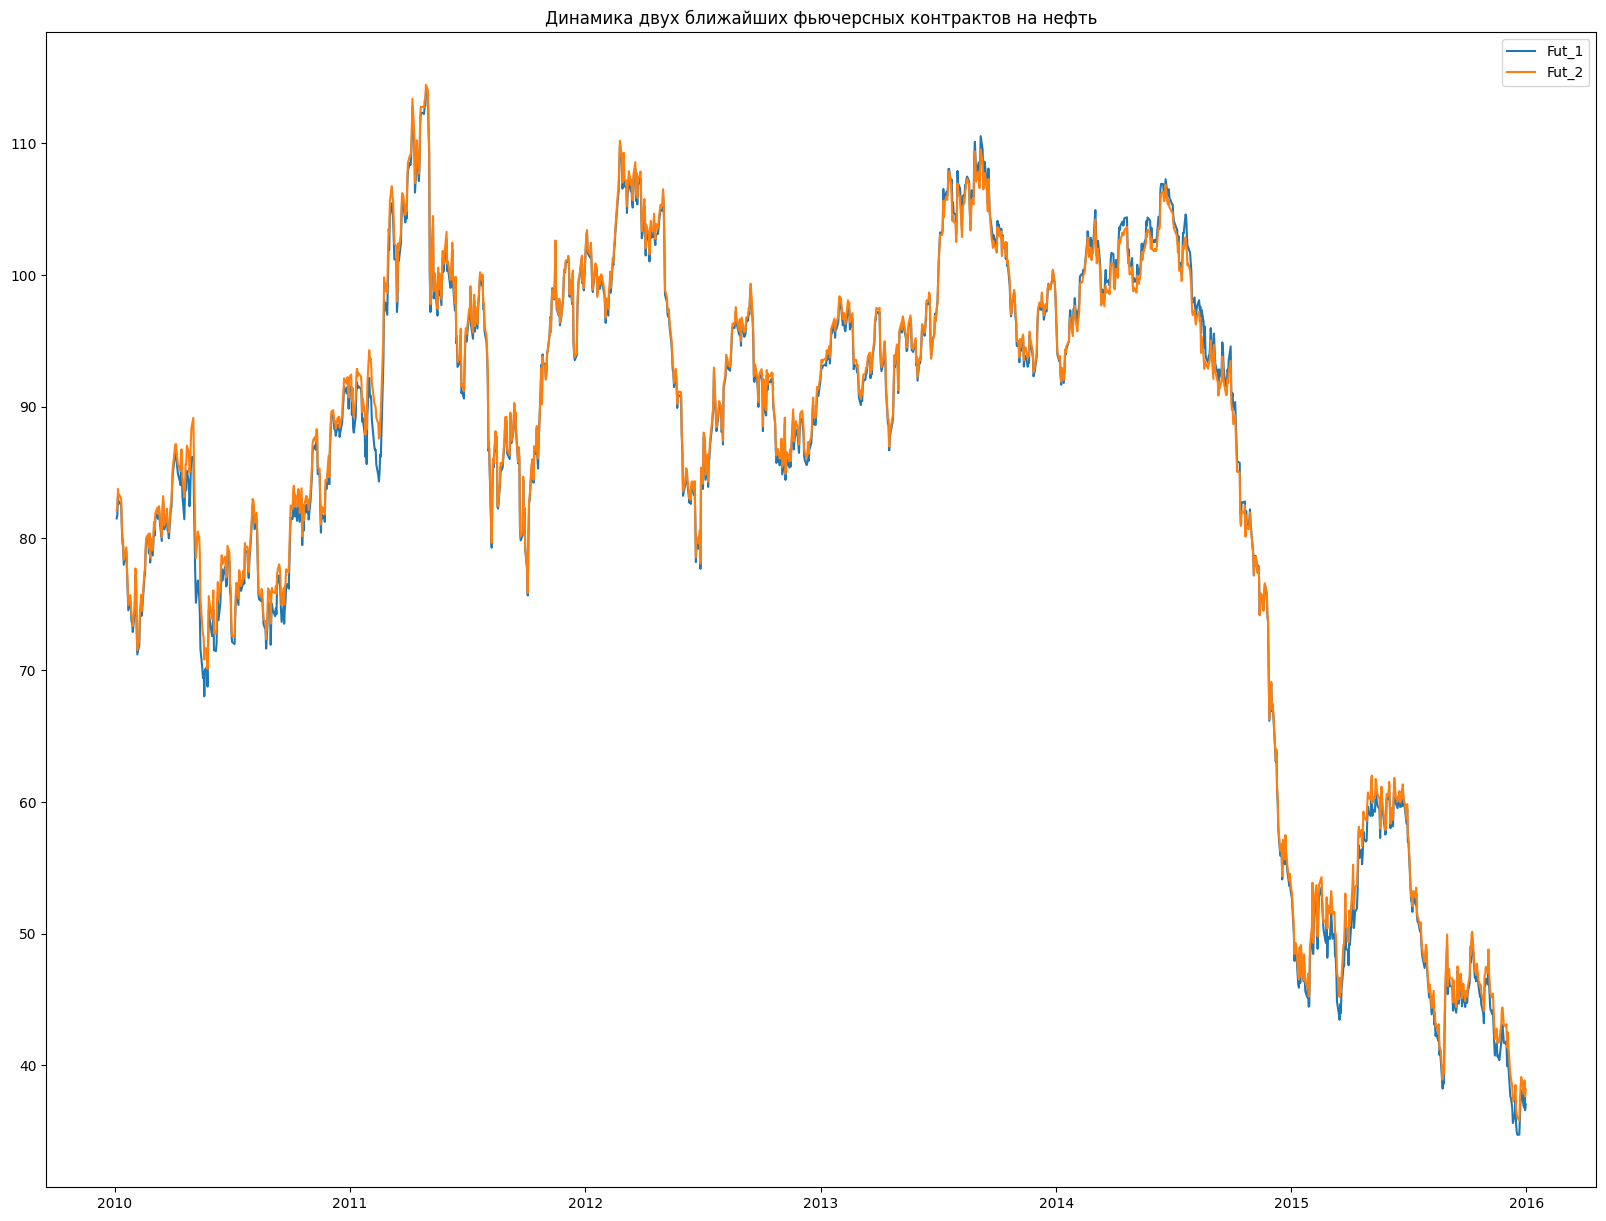

In [86]:
_ = plt.figure(figsize=(20, 15))
_ = plt.plot(Date, Instr_1, label="Fut_1")
_ = plt.plot(Date, Instr_2, label="Fut_2")
_ = plt.title("Динамика двух ближайших фьючерсных контрактов на нефть")
__ = plt.legend()

In [87]:
# инициализация параметров стратегии
days_stationarity_check_max = 20  # частота проверки на стационарность
days_position_max = 3  # количество дней, которые мы держим позицию
window = 250  # количество данных, используемых для проверки стационарности
k = 0.5  # mu +/- k*sigma
comission = 0  # размер комиссиии
stop_profit = 0.001

In [88]:
# инициализация переменных
result = []  # массив для фиксации результатов
stationarity_check = False
pos_days = 0
i = window
stationarity_check_index = window

In [89]:
while (i) < n:
    # print(i)
    if pos_days == 0:
        if ((i - stationarity_check_index) >
                days_stationarity_check_max) | (i == window):
            resid, beta = reg_resid_func(Instr_1[(i - window):i],
                                         Instr_2[(i - window):i])
            stationarity = stationarity_check_func(
                resid)  # проверка на стационарность
            if stationarity:
                mean, sigma = param_func(resid)
            stationarity_check_index = i
        if stationarity:  # если ряд стационарен, проверяем наличие сигнала
            price_1, price_2 = get_prices(Instr_1[i], Instr_2[i])
            spread = float(np.log(price_1) - np.log(price_2) * beta)
            signal = signal_func_open(spread, mean, sigma, k)
            # print(spread,mean,sigma,(mean+sigma*k))
            # print(signal)
            if signal != "No":  # если есть сигнал, занимаем позицию
                pos_direction = "Long" if signal == "Buy" else "Short"
                pos = Position()
                pos.initial_position = (
                    Date[i],
                    pos_direction,
                    price_1,
                    price_2,
                    beta,
                    comission,
                )
                pos_days = 1
                i += 1
            else:
                i += 1
        else:
            i += 1
    else:
        price_1, price_2 = get_prices(Instr_1[i], Instr_2[i])
        if (pos_days < days_position_max
            ):  # если время позиции не превысило лимит, проверяем результат
            pos.close_position = (Date[i], "Signal", price_1, price_2,
                                  comission)
            res = pos.get_result()
            if res > stop_profit:  # если результат положительный, закрываем позицию
                result.append(
                    list(pos.initial_position) + list(pos.close_position) +
                    [round(pos.get_result(), 4)])
                pos_days = 0
            else:
                pos_days += 1
                i += 1
        else:
            pos.close_position = (Date[i], "Time", price_1, price_2, comission)
            # если время позиции превысило лимит, закрываем позицию
            result.append(
                list(pos.initial_position) + list(pos.close_position) +
                [round(pos.get_result(), 4)])
            pos_days = 0
            # print('Time_close')

In [90]:
df = pd.DataFrame(
    result,
    columns=[
        "Date_open",
        "Direction",
        "Price_1_init",
        "Price_2_init",
        "Beta",
        "Comission_init",
        "Date_close",
        "Type",
        "Price_1_close",
        "Price_2_close",
        "Comission_close",
        "Result",
    ],
)
# массив с результатами реализации стратегии

In [91]:
df

,Date_open,Direction,Price_1_init,Price_2_init,Beta,Comission_init,Date_close,Type,Price_1_close,Price_2_close,Comission_close,Result
0,2011-03-08,Short,105.02,105.95,0.996848,0,2011-03-09,Signal,104.38,105.61,0,0.0029
1,2011-03-15,Short,97.18,97.98,0.996848,0,2011-03-16,Signal,97.98,98.95,0,0.0016
2,2011-03-18,Short,101.07,101.85,0.996848,0,2011-03-22,Signal,104.00,104.97,0,0.0015
3,2011-03-23,Short,105.75,106.21,0.996848,0,2011-03-28,Time,103.98,104.56,0,0.0013
4,2011-03-28,Short,103.98,104.56,0.996848,0,2011-03-31,Time,106.72,107.24,0,-0.0008
5,2011-03-31,Short,106.72,107.24,0.996789,0,2011-04-05,Time,108.34,108.99,0,0.0011
6,2011-04-05,Short,108.34,108.99,0.996789,0,2011-04-08,Time,112.79,113.37,0,-0.0010
7,2011-04-08,Short,112.79,113.37,0.996789,0,2011-04-12,Signal,106.25,106.97,0,0.0018
8,2011-04-12,Short,106.25,106.97,0.996789,0,2011-04-15,Time,109.66,110.22,0,-0.0018
9,2011-04-15,Short,109.66,110.22,0.996789,0,2011-04-20,Time,111.45,111.91,0,-0.0010


In [92]:
sum(df.Result * 1000000)  # результат стратегии для 1 млн. USD - 50 пар

9700.0

C:\Users\drouni\AppData\Local\Temp\ipykernel_13648\536341799.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(df.Date_open,


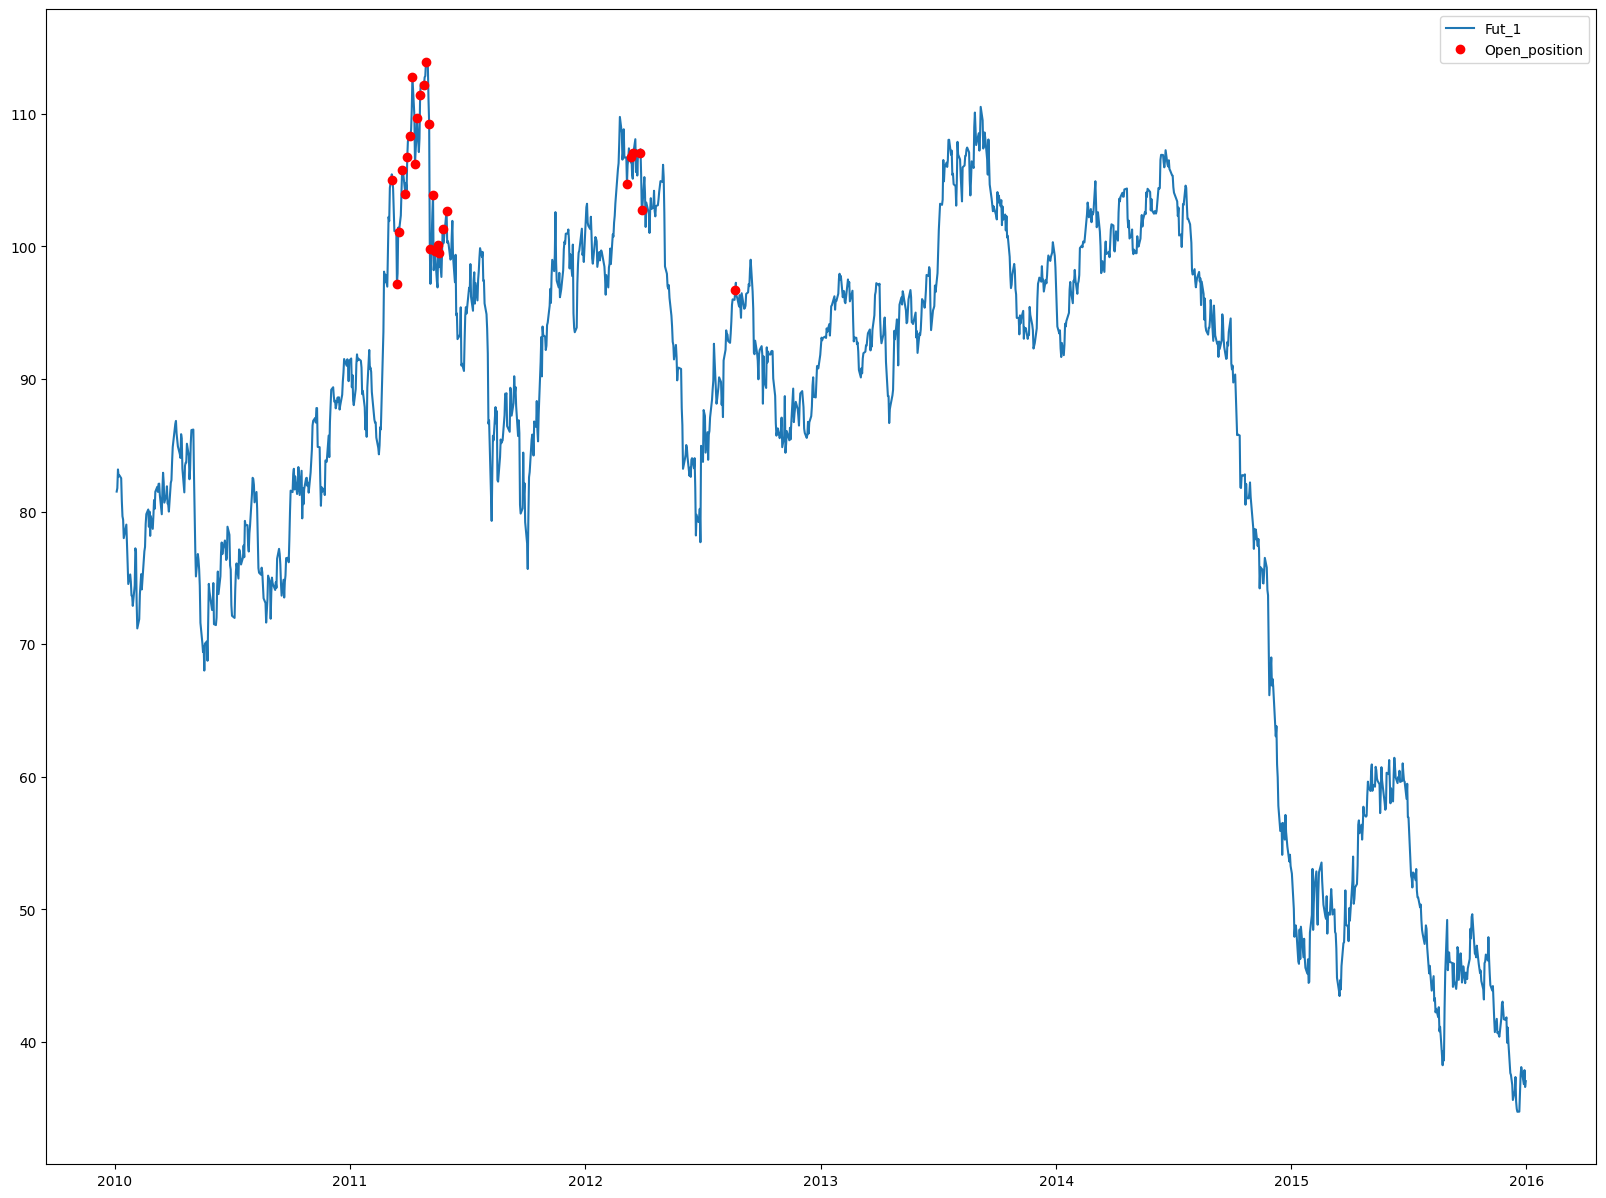

In [93]:
_ = plt.figure(figsize=(20, 15))
_ = plt.plot(Date, Instr_1, label="Fut_1")
# _=plt.plot(Date,Instr_2,label='Fut_2')
plt.plot(df.Date_open,
         df.Price_1_init,
         "bo",
         color="red",
         label="Open_position")
__ = plt.legend()

## Задание


### 1. Выбрать два актива, зависящих от сходных экономических факторов (или факторов риска).

### 2. Протестировать стратегию статистического арбитража по аналогии с разобранным примером.

### 3. Сделать выводы
